# `photutils` SExtractor Background

In this tutorial, I will demonstrate the usage of SExtractor background estimation. SExtractor has complicated algorithm and requires more computation time than usual annulus sky estimation, but is convenient in Python, so let me first demonstrate SExtractor sky (background) estimation. There are many other options for sky subtraction, but it's conventional and reliable to use SExtractor agains other methods.

## SExtractor Algorithm

Basic algorithm is explained in [this section](https://photutils.readthedocs.io/en/stable/photutils/background.html#d-background-and-noise-estimation) of the `photutils` documentation. SExtractor background estimation is done like this:

1. Chop image into a low-resolution image 
  * In case of the axis length is not an integer multiple of corresponding `box_size`, you have to specify the option (`edge_method`). But it is highly recommended not to make such situation, so set `box_size` carefully.

2. For each box ("pad") having `box_size`, do a median filtering with given filter size.
  * The median filter will use `numpy.nan` for "outside-pad" pixels. FYI, the [`photutils.Background2D` source code](https://photutils.readthedocs.io/en/stable/_modules/photutils/background/background_2d.html#Background2D) uses [`scipy.ndimage.generic_filter`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.generic_filter.html#scipy.ndimage.generic_filter), and has the following code:
```python
self.background_mesh = generic_filter(
        self.background_mesh, nanmedian_func, size=self.filter_size,
        mode='constant', cval=np.nan)
```

3. Do the sigma-clipping based on `sigma_clip` to each of the pixel within the box after this median filtering.
  * The clipping is done from *median*, not from *mean*.
  
4. For the low-resolution image, do an interpolation to make a background map (1000 by 1000 pixels).
  * By default, 3rd order spline fitting is used (as SExtractor default). In `photutils`, it is called [`BkgZoomInterpolator`](https://photutils.readthedocs.io/en/stable/api/photutils.background.BkgZoomInterpolator.html#photutils.background.BkgZoomInterpolator)
  * Unlike median filtering, it has `cval=0.0`, so the values outside the range of interpolation is considered as zero-valued pads.
  * To change this, use the parameter `interpolator`.
  
5. You may need some uncertainty map for the background estimation uncertainty, which is done by tuning the paramter `bkgrms_estimator`. It has the input [`StdBackgroundRMS`](https://photutils.readthedocs.io/en/stable/api/photutils.background.StdBackgroundRMS.html#photutils.background.StdBackgroundRMS) by default. This just calculates the sample standard deviation of the sigma-clipped data within each pad, and takes it as the pad's background estimation RMS (roughly equal to what we call "uncertainty"). Then this low-resolution error map is also interpolated by the same way as the background value map.

Here, each pixel of the low-resolutioned image or the low-resolutioned image itself is called *background mesh*, *pad*, or *box*.
  

### Simple Example
It's better to look at an example to understand what the above explanation means. 

For example, say the image was 1000 by 1000 pixel, and you set `box_size = (50, 25)`. Then a low-resolution image consists of 20 by 40 "pads" or "meshes" will be made. Each pad will of course have size of 50 by 25. 

If `filter_size = 3` (eqauivalent to use `filter_size = (3, 3)`), a 3 by 3 median filter will be used to reduce sharp noised pixels at each pad. The median filtering of a pad will make an image of 50 by 25. 

In this median-filtered pad, the sigma-clipping is done. If too many pixels inside a pad is rejected, that pad is rejected for background estimation. By default, `photutils` take `exclude_mesh_method='threshold'` and `exclude_mesh_percentile=10`, which means the pad with more than 10% of pixels are rejected will be rejected. 

* **??**: I got stuck at a point that changing `exclude_mesh_percentile` does not seem to change the background estimation at all in `Background2D`. I will update this part when I get an answer from developers. (I couldn't fully understand the source code of `Background2D`)

Then the representative background value from each pad (which has already been median filtered and sigma-clipped) by the following algorithm:

1. Use `2.5 * median - 1.5 mean`. This is a mode estimator.
  * IRAF uses `3.0 * median - 2.0 mean`, and IDL MMM uses `3.0 * median - 3.0 mean`.
2. Use `median` when `(mean - median) / std > 0.3`.
  * SExtractor user manual has some typo at page 17. This is what it actually does.
  
Once the sky value is set for each pad, it does spline fitting of order 3 to the low-resolution map, i.e., the 20 by 40 image. Then by this fitting, the sky value is given to each of the pixel, i.e., the "sky map" of 1000 by 1000 pixel.

For the sky value at each pixel, we should have some uncertainty. As a rule-of-thumb, the standard deviation of the median filtered and sigma-clipped image is used. For each pad, this value is saved as a representative error, so we have 20 by 40 error map. The 3rd order spline fitting is also done for this error map. Then we finally have the "sky error map" of 1000 by 1000 pixel.



* **TIP**: If you are familiar with the `photutils` code, you may wonder what will happen if you put `sigma_clip` to the `Background2D` and the `SExtractorBackground`. The `bkg_estimator` part of this [`Background2D` document](https://photutils.readthedocs.io/en/stable/api/photutils.background.Background2D.html#photutils.background.Background2D) says the sigma clipping parameter from `SExtractorBackground` will be ignored.

### HST Example
Now let me show you how this SExtractor actually works in Python. More explanations will be given after.

In [19]:
from photutils import Background2D, SigmaClip, MedianBackground, SExtractorBackground
from astropy.io import fits
import numpy as np

hdu = fits.open('HST_Tutorial/M13.fits')
img = hdu[0].data[900:1200, 900:1200]
# if image value < 10^(-6), replace the pixel as 10^(-6)
img[img < 1.e-6] = 1.e-6
FWHM = 2.5

box  = np.array((30, 30)).astype(int)         # 30 by 30 box, so 10 by 10 mesh.
filt = np.array((2*FWHM, 2*FWHM)).astype(int)
sigma_clip = SigmaClip(sigma=3., iters=10)

# The "median" background estimation method
bkg_med = Background2D(img, 
                       box_size=box, 
                       filter_size=filt,
                       sigma_clip=sigma_clip, 
                       bkg_estimator=MedianBackground())

# The SExtractor method
bkg_sex = Background2D(img, 
                       box_size=box, 
                       filter_size=filt,
                       sigma_clip=sigma_clip, 
                       bkg_estimator=SExtractorBackground())

print('method |  bkg med   rms_med')
print('-------+---------------------')
print('median | {0:9.7f}  {1:9.7f}'.format(bkg_med.background_median, bkg_med.background_rms_median))
print('sex    | {0:9.7f}  {1:9.7f}'.format(bkg_sex.background_median, bkg_sex.background_rms_median))



method |  bkg med   rms_med
-------+---------------------
median | 0.0149904  0.0010368
sex    | 0.0147851  0.0010368


What I printed is the median of the background value and RMS of it (the error), for two different sky estimation algorithms: the median and SExtractor. How different are they?

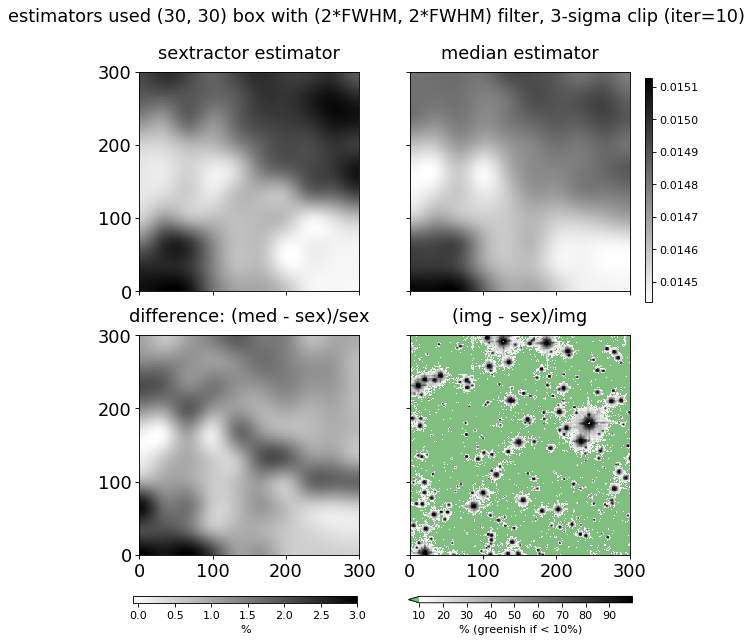

In [22]:
from matplotlib import pyplot as plt

# The difference between the background maps in % (100*(med-sex)/sex)
bkg_diff = (bkg_med.background - bkg_sex.background)/bkg_sex.background * 100

# The ratio between the background subtracted image and the origina image in %
img_sex_ratio = (img - bkg_sex.background)/img * 100

# Plot
fig = plt.figure(figsize=(8,8), dpi=80)

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax4.get_yticklabels(), visible=False)
plt.setp((ax1, ax2, ax3, ax4),
         xlim=[0, 300], ylim=[0, 300],
         xticks=np.arange(0, 301, 100),
         yticks=np.arange(0, 301, 100))

ax1.set_xticks(np.array([0, 100, 200, 300]))
plt.suptitle('estimators used (30, 30) box with (2*FWHM, 2*FWHM) filter, 3-sigma clip (iter=10)', fontsize=16)
im1 = ax1.imshow(bkg_sex.background, origin='lower', cmap='gray_r')
im2 = ax2.imshow(bkg_med.background, origin='lower', cmap='gray_r')
im3 = ax3.imshow(bkg_diff, origin='lower', cmap='gray_r')
im4 = ax4.imshow(img_sex_diff, origin='lower', cmap='gray_r', vmin=10)
ax1.set_title('sextractor estimator', fontsize=16, y=1.03)
ax2.set_title('median estimator', fontsize=16, y=1.03)
ax3.set_title('difference: (med - sex)/sex', fontsize=16, y=1.03)
ax4.set_title('(img - sex)/img', fontsize=16, y=1.03)
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)

cbar_ax12 = fig.add_axes([0.92, 0.52, 0.01, 0.35]) # left, bottom, width, height
cbar_ax3  = fig.add_axes([0.12, 0.05, 0.35, 0.01]) # left, bottom, width, height
cbar_ax4  = fig.add_axes([0.55, 0.05, 0.35, 0.01]) # left, bottom, width, height
fig.colorbar(im1, cax=cbar_ax12)
fig.colorbar(im3, cax=cbar_ax3,
             orientation='horizontal',
             label='%')
fig.colorbar(im4, cax=cbar_ax4,
             orientation='horizontal',
             extend='min',
             label='% (greenish if < 10%)').cmap.set_under('green', alpha=0.5)
plt.show()
# If (img-bkg)/img < 10%, the pixel is likely a meaningless background.
#plt.savefig('bkg_sex+med.png', bbox_inches='tight')
#plt.clf()

The top left ang top right figures show the background map of median and SExtractor algorithms, respectively. 

The bottom left figure is the difference between those two algorithms. See that the difference is less than around 3 percent, which is ~0.0003 in absolute value (electrons per second). 

The bottom right panel is the image which shows the ratio between the original image and the sky subtracted image. If this is around 100%, it means the sky subtraction is not so significant, i.e., the bright source is there. If this is small (say < 10%, which is indicated as greenish color), it means the sky subtraction made the pixel value nearly zero, i.e., no source was there. 

The next code is to show you how the low-resolution to high-resolution restoration of sky and sky subtraction works:

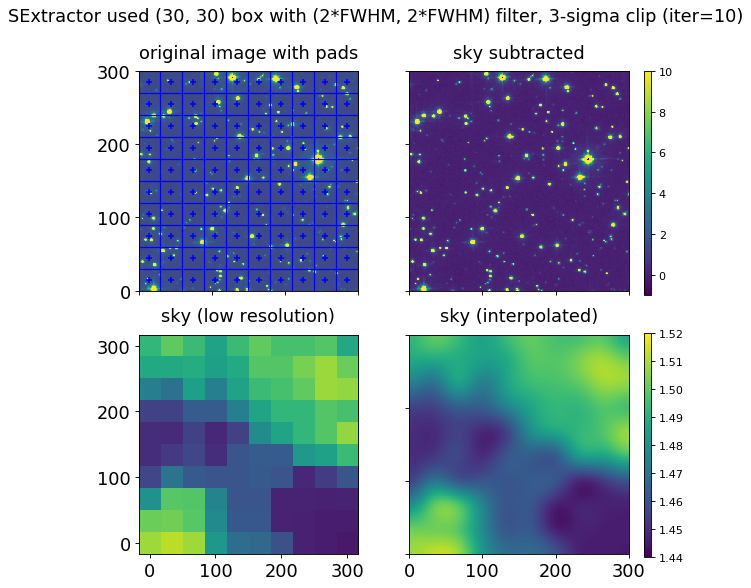

In [33]:
fig = plt.figure(figsize=(8,8), dpi=80)

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax4.get_yticklabels(), visible=False)
plt.setp((ax1, ax2, ax4),
         xlim=[0, 300], ylim=[0, 300],
         xticks=np.arange(0, 301, 100),
         yticks=np.arange(0, 301, 100))
plt.setp(ax3,
#         xlim=[0, 10], ylim=[0, 10],
         xticks=np.arange(0, 10, 3),
         yticks=np.arange(0, 10, 3),
         xticklabels=np.arange(0, 301, 100),
         yticklabels=np.arange(0, 301, 100))

#plt.imshow(bkg_sex.background_mesh, origin='lower')
im1 = ax1.imshow(100*img, 
                 vmin=-1, vmax=10, origin='lower')
im2 = ax2.imshow(100*img-100*bkg_sex.background, 
                 vmin=-1, vmax=10, origin='lower')
im3 = ax3.imshow(100*bkg_sex.background_mesh, 
                 vmin=1.44, vmax=1.52, origin='lower')
im4 = ax4.imshow(100*bkg_sex.background, 
                 vmin=1.44, vmax=1.52, origin='lower')
bkg_sex.plot_meshes(ax1, outlines=True)
ax1.set_title('original image with pads', fontsize=16, y=1.03)
ax2.set_title('sky subtracted', fontsize=16, y=1.03)
ax3.set_title('sky (low resolution)', fontsize=16, y=1.03)
ax4.set_title('sky (interpolated)', fontsize=16, y=1.03)
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)

cbar_ax12 = fig.add_axes([0.92, 0.53, 0.01, 0.35]) # left, bottom, width, height
cbar_ax34 = fig.add_axes([0.92, 0.12, 0.01, 0.35]) # left, bottom, width, height

plt.suptitle('SExtractor used (30, 30) box with (2*FWHM, 2*FWHM) filter, 3-sigma clip (iter=10)', fontsize=16)
fig.colorbar(im1, cax=cbar_ax12)
fig.colorbar(im3, cax=cbar_ax34)
plt.show()